In [1]:
import os
import re
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=1000, threshold=1000)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

Using TensorFlow backend.


In [3]:
gridsize = 256

folder = {}
data = {}
kappa = {}
x = {}
y = {}
stencils = {}
dsrcs = ['cds ohne', 'cds mit', 'ml ohne', 'ml mit', 'cvofls']
#dsrcs = ['cds mit', 'ml ohne', 'ml mit']

for dsrc in dsrcs:
    if dsrc == 'cds mit':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cds mit w+g'
    if dsrc == 'cds ohne':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cds ohne w+g'
    elif dsrc == 'ml mit':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} ml mit w+g'
    elif dsrc == 'ml ohne':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} ml ohne w+g'
    elif dsrc == 'cvofls':
        folder[dsrc] = f'2007181652 staticBubble {gridsize} cvofls'
        
    data[dsrc] = pd.read_feather(os.path.join(folder[dsrc], 'res', 'staticbubble.feather'))
    kappa[dsrc] = np.array(data[dsrc].iloc[:, 0])
    stencils[dsrc] = np.array(data[dsrc].iloc[:, 1:-2])
    x[dsrc] = np.array(data[dsrc].iloc[:, -2])
    y[dsrc] = np.array(data[dsrc].iloc[:, -1])
    np.random.seed(3)
    indices = np.random.permutation(kappa[dsrc].shape[0])
    kappa[dsrc] = kappa[dsrc][indices]
    stencils[dsrc] = stencils[dsrc][indices, :]

ML mit = mit w+g, ML ohne = ohne w+g
Mittelwert/Standardabweichung cds mit:	0.4605,	0.3300
Mittelwert/Standardabweichung cvofls:	0.4981,	0.3830
Mittelwert/Standardabweichung ml mit:	0.5094,	0.0851


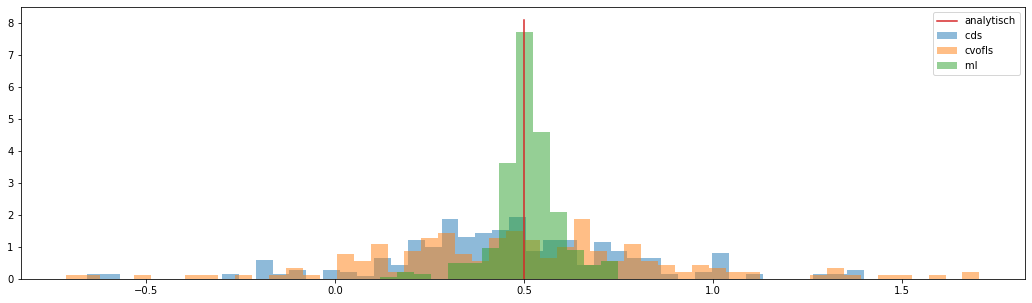

In [4]:
roud = 3
print('ML mit = mit w+g, ML ohne = ohne w+g')
dsrcs = ['cds mit', 'cvofls', 'ml mit']
fig, ax = plt.subplots(figsize = (18,5))
for dsrc in dsrcs:
    print(f'Mittelwert/Standardabweichung {dsrc}:\t{np.mean(kappa[dsrc]):.4f},\t{np.std(kappa[dsrc]):.4f}')
    
    if dsrc == 'cds mit':
        color = 'b'
    elif dsrc == 'cds ohne':
        color = 'k'
    elif dsrc == 'ml mit':
        color = 'r'
    elif dsrc == 'ml ohne':
        color = 'g'
    elif dsrc == 'cvofls':
        color = 'y'
        
    rng = kappa[dsrc].max()-kappa[dsrc].min()
    
    # Vertikal
    ax.hist(kappa[dsrc], bins=int(rng*45*128/gridsize), label=(dsrc if not ('mit' in dsrc) else re.sub('mit', '', dsrc)), alpha=0.5, density=True)
    # Horizontal
    #ax.hist(kappa[dsrc], bins=int(rng*25), label=dsrc, alpha=0.5, density=True, orientation='horizontal')
xlim = ax.get_xlim()[1]
ylim = ax.get_ylim()[1]
#plt.plot([0, xlim], [0.5, 0.5], label='analytisch')
plt.plot([0.5, 0.5], [0, ylim], label='analytisch')
plt.legend()
#x1,x2,y1,y2 = plt.axis()
#plt.axis((0.15,0.85,y1,y2))

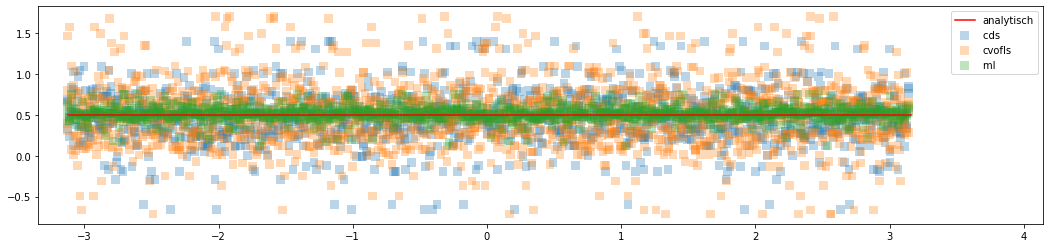

In [6]:
theta = {}
fig, ax = plt.subplots(figsize = (18,4))
alpha = 0.3
marker = ','
size = 75

dsrcs = ['cds mit', 'cvofls', 'ml mit']
#dsrcs = ['cds mit']

for dsrc in dsrcs:
    theta[dsrc] = np.arctan2(y[dsrc]-4, x[dsrc]-4)
    indices = np.argsort(theta[dsrc])
    
    printdata = np.stack((theta[dsrc][indices], kappa[dsrc][indices]))
    
    ax.scatter(printdata[0, :], printdata[1, :], label=(dsrc if not ('mit' in dsrc) else re.sub('mit', '', dsrc)), alpha=alpha, marker=marker, s=size, edgecolors='none')
    #ax.plot(printdata[0, :], printdata[1, :], label=dsrc, alpha=alpha, marker=marker)
ax.plot([-np.pi+0.02, np.pi+0.02], [0.5, 0.5], color = 'r', label='analytisch')
ax.set_xlim([-np.pi-0.2, np.pi+1])
ax.legend()
    